In [45]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [46]:
###-----------------
### Import Libraries
###-----------------

import os
import time
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from torchvision import datasets, transforms, models

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [47]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName = 'dnet_flowers'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)


trainModel = False   # True(alternate)
EPOCHS = 200 # number of epochs

BATCH_SIZE = 32



TRAIN_SIZE = 92*BATCH_SIZE

# Input Image size
IMG_HEIGHT = 224     # lower image size will result in lesser accuracy
IMG_WIDTH = 224

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 5

# Learning Rates
ALPHA = 0.001 # learning rate
WEIGHT_DECAY = 0.01

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [48]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [49]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 2060 SUPER


In [50]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Read Flowers data set

In [51]:
###---------------
### Transformation
###---------------

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [52]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 224, 224]), 0)

In [53]:
dataset_size = len(dataset)
train_size = TRAIN_SIZE

test_size = dataset_size - train_size
print (dataset_size, train_size, test_size)

3670 2944 726


In [54]:
indices = torch.randperm(len(dataset)).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(dataset,indices[:train_size])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[train_size:])

In [55]:
len(train_dataset), len(test_dataset)

(2944, 726)

In [56]:
class_names = {}

for count, name in enumerate(train_dataset.dataset.classes):
    class_names[count] = name   # add in the dict

class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [57]:
numClasses = len(class_names)
numClasses

5

In [58]:
modelPath = os.path.join(modelDir, subDir, f'{altName}.pth')

## Data Loader

In [59]:
#torch.utils.data.DataLoader?

In [60]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True,
                                               num_workers=4,
                                               persistent_workers=True,
                                               prefetch_factor=4)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True,
                                               num_workers=4,
                                               persistent_workers=True,
                                               prefetch_factor=4)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

92 22


In [61]:
def fn_showImages(img, ax):
    '''
    Args:
        img: image from torch [c x h x w]
        ax: matplotlib axis object
    '''

    img = img.numpy().transpose((1,2,0))    # converting to channel last

    means = np.array([0.485, 0.456, 0.406]) 
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means  # normalize data
    
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')

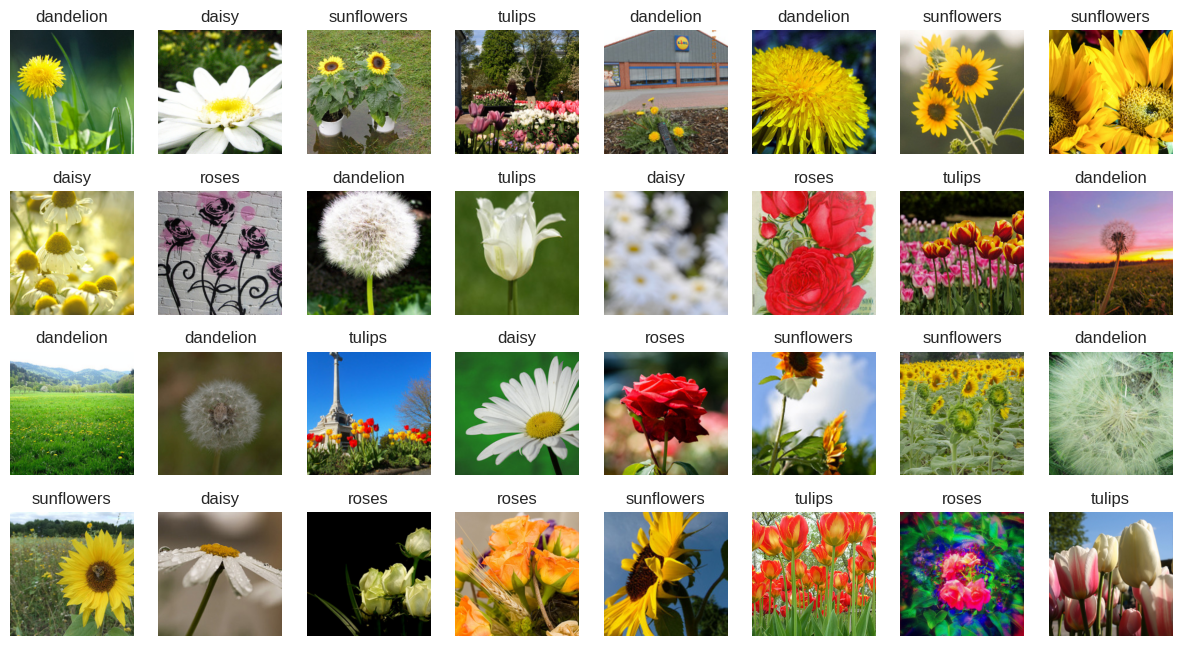

In [62]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].cpu().item()])

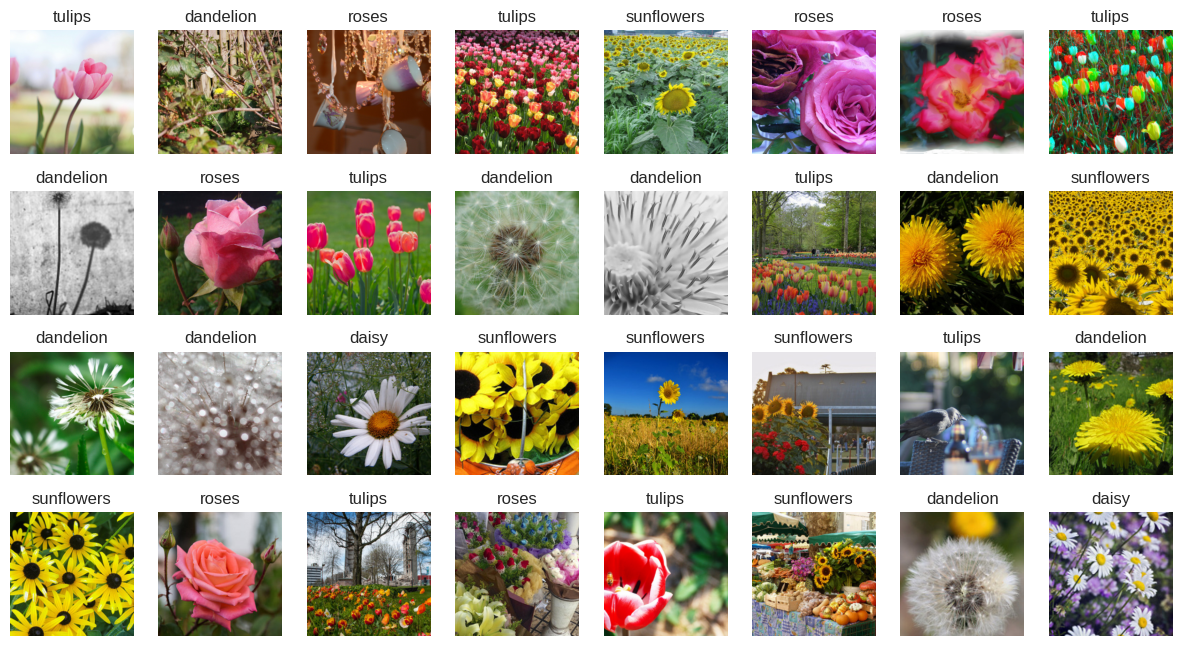

In [63]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].cpu().item()])

In [64]:
# load pretrained DenseNet

model = models.densenet121(weights='IMAGENET1K_V1')
model.classifier = nn.Linear(model.classifier.in_features, numClasses)
#print(model)

In [65]:
class EarlyStopping():
    '''
    Early stopping to stop the training when the loss does not improve after certain epochs.
    '''

    def __init__(self, patience=PATIENCE, min_delta=0):

        '''
        patience: how many epochs to wait before stopping when loss is not improving
        min_delta: minimum difference between new loss and old loss for new loss to be 
        considered as an improvement
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):

        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0 # reset counter if validation loss improves
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            # print(f'[INFO] Early stopping counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                print('[INFO] Early stopping')
                self.early_stop = True

In [66]:
class SaveBestModel:
    '''
    Class to save the best model while training. if the current epoch's validation
    loss is less than the previous minimum, then save the model state.
    '''

    def __init__(self, best_test_loss = float('inf'), bestModelPath = modelPath):
        self.best_test_loss = best_test_loss
        self.modelPath = bestModelPath

    def __call__(self, current_test_loss, epoch, model, optimizer, criterion):
        if current_test_loss < self.best_test_loss:

            self.best_test_loss = current_test_loss
            print(f'[INFO]: saving at epoch: {epoch+1}')
            torch.save({'epoch': epoch+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss':criterion,
                        }, self.modelPath)

In [67]:
# Move model to device
model = model.to(device)

# Initialize our optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=ALPHA, weight_decay=WEIGHT_DECAY)

# loss function
# lossFn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss()

# using scheduler "Reduce on Plateau"
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=1e-7
)

# initializing early stopping
early_stopping = EarlyStopping(patience=PATIENCE)
save_best_model = SaveBestModel()

# initialize a dictionary to store training history
H = {
    'Epoch': [],
    'Train loss': [],
    'Test loss': [],
    'Train acc': [],
    'Test acc': [],
    'Alpha': [],
    'Patience': []
}

In [68]:
if trainModel:

    print("[INFO] training the network...")
    startTime = time.time()

    for epoch in range(0, EPOCHS):

        epochStart = time.time()

        model.train()

        avgTrainLoss = 0
        avgTestLoss = 0

        y_pred = []
        y_true = []

        for count, data in enumerate(train_dataloader):
        
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
            
            # reset optimizer
            optimizer.zero_grad()
            
            # perform a forward pass and calculate the training loss
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
            optimizer.step()

            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            avgTrainLoss += (loss.item() - avgTrainLoss)/(count+1)

            # add labels to the list
            y_true.extend(labels.cpu().numpy())

            # add predictions to the list
            y_pred.extend(outputs.argmax(axis=1).cpu().numpy())

        trainAcc = accuracy_score(y_true, y_pred)

        # Initialize again to store for test data
        y_pred = []
        y_true = []

        # switch off autograd for evaluation
        with torch.no_grad():
            
            # set the model in evaluation mode
            model.eval()

            for count, data in enumerate(test_dataloader):
        
                images, labels = data

                images = images.to(device)
                labels = labels.to(device)
                
                output = model(images)
                avgTestLoss += (loss_fn(output, labels).item() - avgTestLoss)/(count+1)

                # add labels to the list
                y_true.extend(labels.cpu().numpy())

                # add predictions to the list
                y_pred.extend(output.argmax(axis=1).cpu().numpy())
            
            lr_scheduler.step(avgTestLoss)

            save_best_model(avgTestLoss, epoch, model, optimizer, loss_fn)

            early_stopping(avgTestLoss)

            testAcc = accuracy_score(y_true, y_pred)


            curr_alpha = lr_scheduler.get_last_lr()[0]

            # update our training history
            H['Epoch'].append(epoch)
            H['Train Loss'].append(avgTrainLoss)
            H['Test loss'].append(avgTestLoss)
            H['Train acc'].append(trainAcc)
            H['Test acc'].append(testAcc)
            H['Alpha'].append(curr_alpha)
            H['Patience'].append(early_stopping.counter)

            # print the model training and validation information
            print(f'[INFO] EPOCH: {epoch+1}/{EPOCHS}', end = ' ')
            print(f'Loss: {avgTrainLoss:.6f}/{avgTestLoss:.6f}, Accuracy: {trainAcc:.4f}/{testAcc:.4f}', end=' ')
            print(f'Alpha: {curr_alpha:.6f}/{avgTestLoss:.6f}, ES: {early_stopping.counter:3d}', end= ' ')
            print('in: {:.2f}s \n'.format(time.time() - epochStart))

        if early_stopping.early_stop:
            break
    
    # finish measuring how long training took
    endTime = time.time()
    print(f'[INFO] total time taken to train the model: {(endTime - startTime)/60.:.2f} min')
else:
    model_data = torch.load(modelPath, weights_only=False)

    # setting state
    model.load_state_dict(model_data['model_state_dict'])


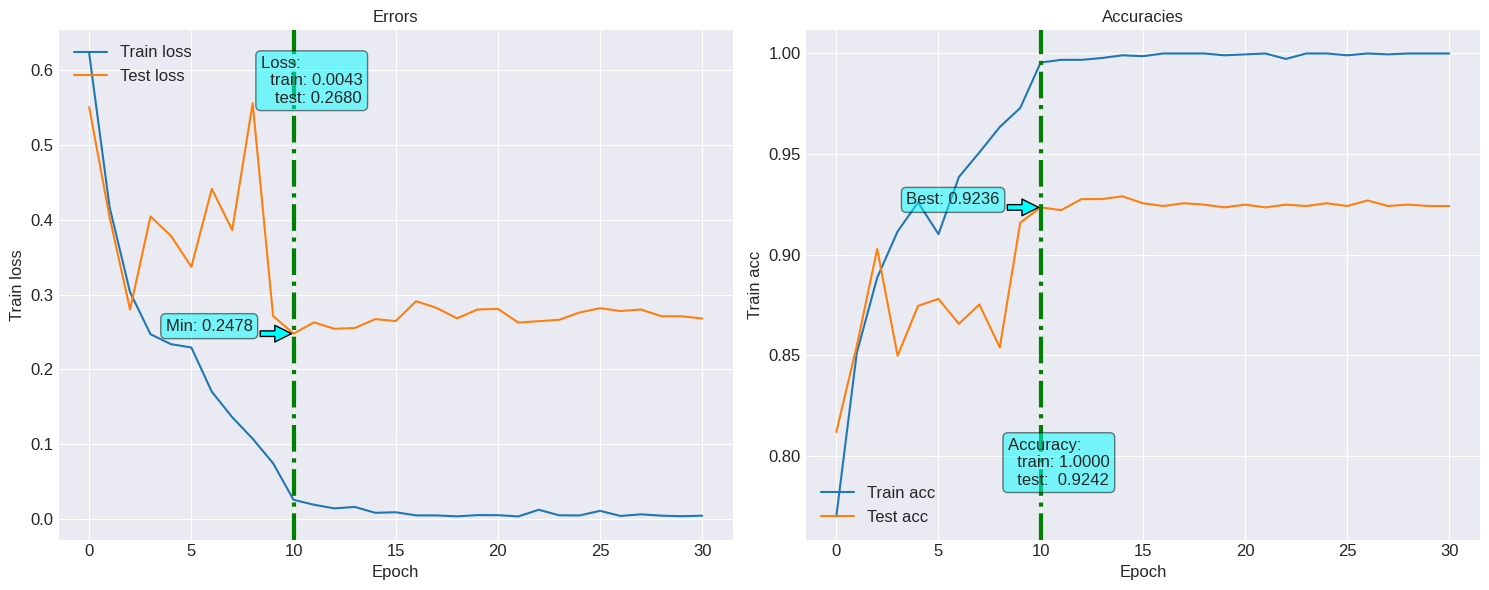

In [69]:
if trainModel:
    loss_df = pd.DataFrame(H)
    loss_df.to_csv(os.path.join(modelDir, subDir, f'{altName}.csv'), index=False)
else:
    loss_df = pd.read_csv(os.path.join(modelDir, subDir, f'{altName}.csv'))

fn_plot_torch_hist(loss_df)

In [70]:
with torch.no_grad():

    model.eval()

    y_pred = []
    y_true = []
    # loop over the test set
    for data in train_dataloader:

        images, labels = data
        # send the input to the device
        images = images.to(device)

        y_true.extend(labels)
         # make the predictions and add them to the list       
        output = model(images)
                
        y_pred.extend(output.argmax(axis=1).cpu().numpy())

In [71]:
print(f'Accuracy_score : {accuracy_score(y_true, y_pred) : .5f}\n')

print(classification_report ( y_true, y_pred, target_names = class_names.values() ) )

Accuracy_score :  0.98200

              precision    recall  f1-score   support

       daisy       1.00      0.99      0.99       502
   dandelion       0.99      0.99      0.99       718
       roses       0.97      0.97      0.97       524
  sunflowers       0.99      0.98      0.99       562
      tulips       0.97      0.98      0.97       638

    accuracy                           0.98      2944
   macro avg       0.98      0.98      0.98      2944
weighted avg       0.98      0.98      0.98      2944



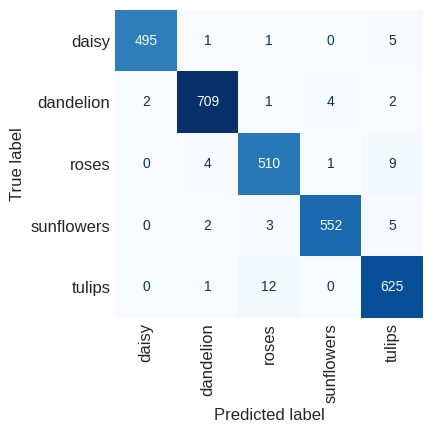

In [72]:
fn_plot_confusion_matrix(y_true, y_pred, class_names)

In [73]:
f1_score(y_true, y_pred, average='weighted')

0.982027243426918

In [74]:
def fn_display_batches(n_batches, dataloader):

    for batch in range(n_batches):

        # Run this to test your data loader
        images, labels = next(iter(dataloader))


        # Predict again to keep y_pred in sync with the images
        images = images.to(device)

        output = model(images)

        y_pred = output.argmax(axis=1).cpu()

        # set figure size
        fig = plt.figure(figsize= (15,4))

        # Adjust the subplot layout parameters.
        fig.subplots_adjust(left=0., # as a fraction of the figure width
                            right=1., # use full width, as a fraction of the figure width
                            bottom=0., # as a fraction of the figure height
                            top=1.,     # as a fraction of the figure height
                            hspace=0.05, # as a fraction of the average Axes height
                            wspace=0.05)
        fontsize = 12

        for i in range (BATCH_SIZE):

            if labels[i]!= y_pred[i]:
                fc ='red'
                ec='red'
                text_color= 'yellow'
            else:
                fc ='cyan'
                ec='blue'
                text_color= 'blue' 
            
            props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec=ec)

            ax = fig.add_subplot(BATCH_SIZE //8, 8, (i+1), xticks=[], yticks=[])
            
            fn_showImages(images[i].cpu(),ax=ax)
            

            ax.text(0.1, 0.95, class_names[y_pred[i].item()], transform=ax.transAxes,fontsize=fontsize, color= text_color, verticalalignment='top', bbox=props)

            ax.set_title(class_names[labels[i].item()])

            ax.axis("off")

        plt.tight_layout()

        plt.show()

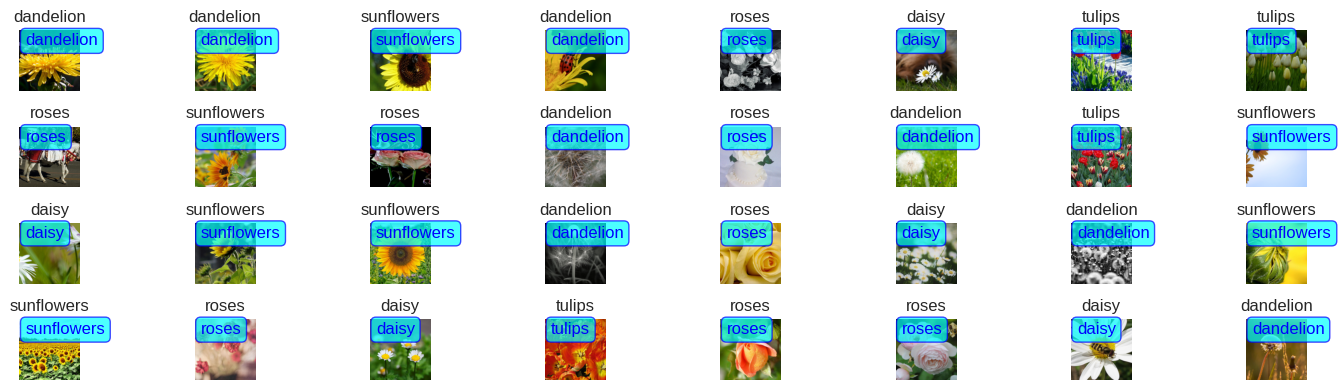

In [75]:
fn_display_batches(1, train_dataloader)

#### Testing

In [76]:
with torch.no_grad():

    model.eval()

    y_pred = []
    y_true = []
    # loop over the test set
    for data in test_dataloader:

        images, labels = data
        # send the input to the device
        images = images.to(device)

        y_true.extend(labels)
         # make the predictions and add them to the list       
        output = model(images)
                
        y_pred.extend(output.argmax(axis=1).cpu().numpy())

In [77]:
print(f'Accuracy_score : {accuracy_score(y_true, y_pred) : .5f}\n')

print(classification_report ( y_true, y_pred, target_names = class_names.values() ) )

Accuracy_score :  0.92011

              precision    recall  f1-score   support

       daisy       0.94      0.92      0.93       131
   dandelion       0.94      0.92      0.93       180
       roses       0.88      0.95      0.91       117
  sunflowers       0.93      0.91      0.92       137
      tulips       0.90      0.91      0.90       161

    accuracy                           0.92       726
   macro avg       0.92      0.92      0.92       726
weighted avg       0.92      0.92      0.92       726



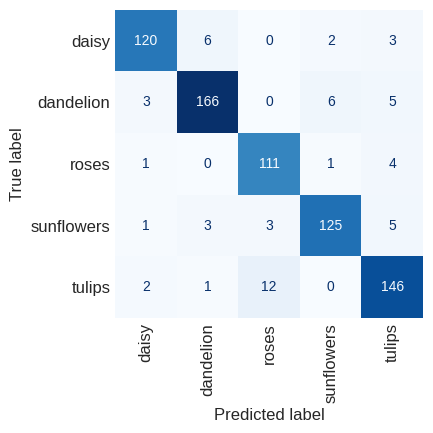

In [78]:
fn_plot_confusion_matrix(y_true, y_pred, class_names)

In [79]:
f1_score(y_true, y_pred, average='weighted')

0.9202438730223568

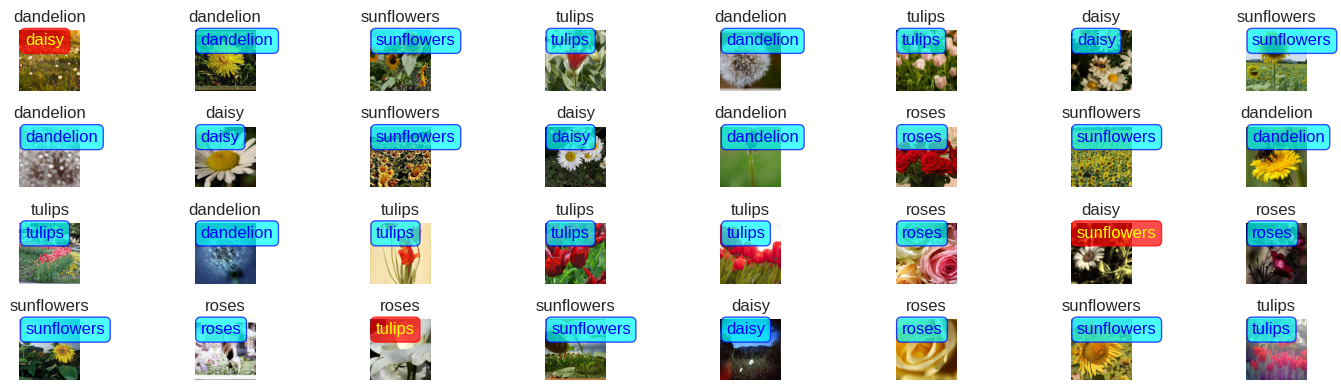

In [80]:
fn_display_batches(1, test_dataloader)

### Valid Flowers data

In [81]:
valDir = 'valid_flowers'
valid_dir = os.path.join(inpDir, valDir)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)


valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True,
                                               num_workers=4,
                                               persistent_workers=True,
                                               prefetch_factor=4)

In [82]:
with torch.no_grad():

    model.eval()

    y_pred = []
    y_true = []
    # loop over the test set
    for data in valid_dataloader:

        images, labels = data
        # send the input to the device
        images = images.to(device)

        y_true.extend(labels)
         # make the predictions and add them to the list       
        output = model(images)
                
        y_pred.extend(output.argmax(axis=1).cpu().numpy())

In [83]:
print(f'Accuracy_score : {accuracy_score(y_true, y_pred) : .5f}\n')

print(classification_report ( y_true, y_pred, target_names = class_names.values() ) )

Accuracy_score :  0.87446

              precision    recall  f1-score   support

       daisy       0.97      0.86      0.92        44
   dandelion       0.89      0.93      0.91        42
       roses       0.86      0.82      0.84        45
  sunflowers       0.92      0.90      0.91        50
      tulips       0.77      0.86      0.81        50

    accuracy                           0.87       231
   macro avg       0.88      0.87      0.88       231
weighted avg       0.88      0.87      0.88       231



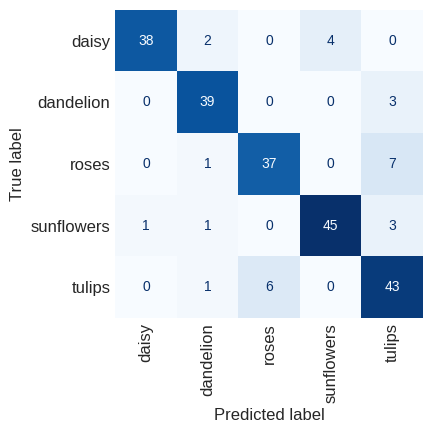

In [84]:
fn_plot_confusion_matrix(y_true, y_pred, class_names)

In [85]:
f1_score(y_true, y_pred, average='weighted')

0.8755137323100588

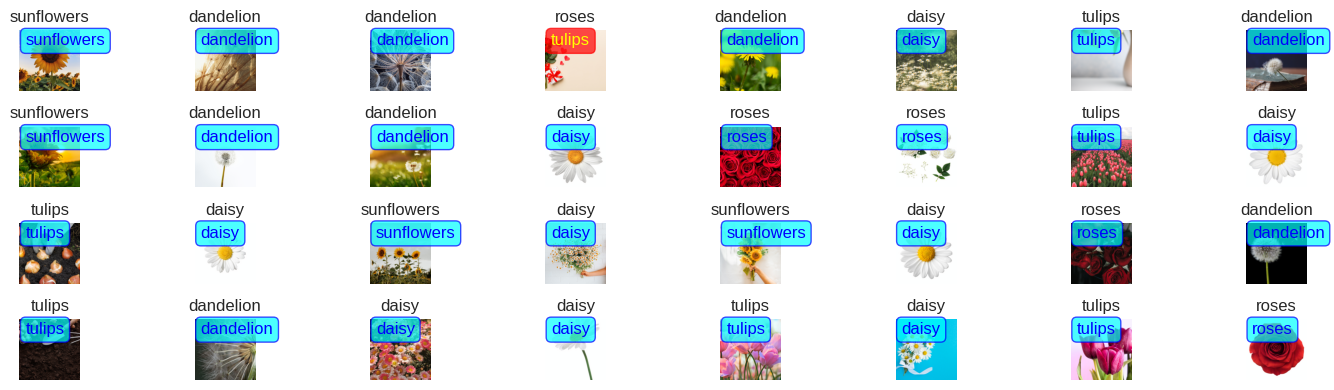

In [86]:
fn_display_batches(1, valid_dataloader)